In [1]:
import glob
from bs4 import BeautifulSoup
import requests
from selenium import webdriver
import time
import pickle
import numpy as np
from tqdm.notebook import tqdm as tqdm_notebook
import re
import collections
import glob
from transformers import DistilBertTokenizer, DistilBertModel, logging
import sys
import time
import requests
import random
from IPython.display import display, HTML
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup

logging.set_verbosity_error()
sys.path.insert(0, '../src/models/')
sys.path.insert(0, '../src/features/')

from predict_model import loadBERT
from predict_model import SpanPredictor as classify
from build_features import text_cleaner, DuckDuckGo_Java, Bing_HTML, colorize_prediction

In [242]:
def normal_graph(species, data, sent_start=0, sent_end=999, k=0.08, scale=0.3, iterations=50, size=1.5):
    source   = []
    relation = []
    target   = []
    baseparts = []
    traits = []
    
    for _, (sub, rel, obj) in data[species][sent_start:sent_end]:
        if sub == 'species':
            sub = species
        source.append(sub)
        relation.append(rel)
        target.append(obj)
        if rel == 'has main part':
            baseparts.append(obj)
        if rel == 'has part':
            traits.append(obj)

    kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relation})
    nodes = [(source, target) for source, target in zip(kg_df['source'].values, kg_df['target'].values)]
    G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                              edge_attr=True, create_using=nx.Graph())


    node_labels = {node : node for idx, node in enumerate(G)}
    edge_labels = dict(zip(list(zip(kg_df.source, kg_df.target)),
                      kg_df['edge'].tolist()))

    node_size = {}
    node_color = {}
    size = size
    for node in node_labels:
        if node == species:
            node_size[node] = 3.5/size
            node_color[node] = 'darkgreen'
        elif node in baseparts:
            node_size[node] = 2./size
            node_color[node] = 'green'
        elif node in traits:
            node_size[node] = 1.5/size
            node_color[node] = 'lightgreen'
        else:
            node_size[node] = 1./size
            node_color[node] = 'white'
    pos = nx.spring_layout(G, k = k, iterations=iterations, seed=3, scale=scale, center=(0,0), dim=2)
    return pos, nodes, node_size, node_color, node_labels, edge_labels

def weighted_graph(species, data, sent_start=0, sent_end=999, k=0.08, scale=0.3, iterations=50, size=1.5, log=True):
    
    RDF_dict_text = collections.defaultdict(list)
    baseparts = []
    traits   = []
    source   = []
    relation = []
    target   = []
    colors   = {}
    low = 1
    high = 0

    for color, (sub, rel, obj) in data[species][sent_start:sent_end]:
        if sub == 'species':
            sub = species
        source.append(sub)
        relation.append(rel)
        target.append(obj)
        colors[obj] = color
        if rel == 'has main part':
            baseparts.append(obj)
        if rel == 'has part':
            traits.append(obj)

        if low > color:
            low = color
        if high < color:
            high = color
    kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relation})
    if log:
        norm = mcolors.LogNorm(vmin=low, vmax=high)
    else:
        norm = mcolors.Normalize(vmin=low, vmax=high)
    cmap = matplotlib.cm.viridis
    nodes = [(source, target) for source, target in zip(kg_df['source'].values, kg_df['target'].values)]
    G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                              edge_attr=True, create_using=nx.Graph())

    node_labels = {node : node for idx, node in enumerate(G)}
    edge_labels = dict(zip(list(zip(kg_df.source, kg_df.target)),
                      kg_df['edge'].tolist()))
    node_size = {}
    node_color = {}
    size = size
    for node in node_labels:
        #node_size[node] = 3.5/size
        if node == species:
            node_color[node] = 'darkgreen'
            node_size[node] = 3.5/size
        else:
            node_color[node] = cmap(norm(colors[node]))
            if node in baseparts:
                node_size[node] = 2/size
            elif node in traits:
                node_size[node] = 1.5/size
            else:
                node_size[node] = 1/size               
    return nodes, node_size, node_color, node_labels, edge_labels
        
#pos = nx.spring_layout(G, k = 0.023, iterations=100, seed=33, dim=2,scale=0.8, center=(0,0))

In [2]:
model = loadBERT("../models/", 'saved_weights_inf_FIXED_boot_beta80.pt')
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

CPU Success


In [ ]:
'''
URL = "https://identify.plantnet.org/monver/species/all"
browser = webdriver.Safari()
time.sleep(2)
browser.get(URL)
HTML = browser.page_source
soup = BeautifulSoup(HTML, 'html.parser')
browser.close()

species = []
for span in soup.find_all('a'):
    try:
        if span['href'].startswith('/monver/species/'):
            if span['href'].endswith('data'):
                species.append(span.text.strip())
    except:
        continue
        
with open('../data/external/PlantNET_plants.pkl', 'wb') as f:
    pickle.dump(species, f) 
'''

In [3]:
PlantNET_species = pickle.load(open('../data/PlantNet/species.pkl', 'rb'))
#random.shuffle(PlantNET_species)

In [ ]:
#PlantNET_species.index('Osmanthus fragrans Lour.')

In [ ]:
descriptions = collections.defaultdict(list)
for species in tqdm_notebook(PlantNET_species[0:], desc='Species', leave=True):
    
    # Create links and open
    links = []
    try:
        google_result = f"../data/PlantNet/google_results/{species.replace(' ', '_')}.pkl"
        links += pickle.load(open(google_result, 'rb'))
        duck_result   = f"../data/PlantNet/duck_results/{species.replace(' ', '_')}.pkl"
        links += pickle.load(open(duck_result, 'rb'))
    
    except:
        duck_result   = f"../data/PlantNet/duck_results/{species.replace(' ', '_')}.pkl"
        links += pickle.load(open(duck_result, 'rb'))

    
    links = list(set(links))
    #for URL in tqdm_notebook(links, desc='URL', leave=False):    
    for URL in links:      
        try:
            page = requests.get(URL, timeout=5)  
            soup = BeautifulSoup(page.content, "lxml", from_encoding="iso-8859-1")
            if bool(set(species.split()).intersection(soup.title.text.split())):
                dirty_text = soup.get_text(" ", strip=False).replace('\n', '.')
                sentences = text_cleaner(dirty_text)
                for sentence in sentences:
                    if classify(sentence, model=model):
                        descriptions[species].append(sentence)
        except:
            #print(f'{species} --- {URL} error!')
            continue
    print(species, len(descriptions[species]))

In [ ]:
with open(f'../data/PlantNet/descriptions_raw.pkl', 'wb') as f:
        pickle.dump(descriptions, f)  

# Extract Info

See the other notebook

## Branch Importance

In [4]:
from predict_model import load_CUB_Bert as load_model
from scipy.special import softmax
from sklearn.preprocessing import LabelBinarizer
import torch

In [5]:
output = 226
# Load the model
model = load_model("../models/", 'saved_weights_PlantSpecies_PlantNet_226_v2.pt', outputsize=output)

Local Success


In [6]:
# Load the text and the triples
text_dict = pickle.load(open('../data/PlantNet/descriptions_triples_text_v2.pkl', 'rb'))
triples_dict = pickle.load(open('../data/PlantNet/descriptions_triples_rdf_v2.pkl', 'rb'))

In [7]:
# Create vectors and extract species
lb = LabelBinarizer()
keys = np.array([key for key in text_dict.keys()])
keys_encoded = lb.fit_transform(keys)
species_list = list(triples_dict.keys())

In [8]:
# Create predictor
def WhichPlant(span, model):
    with torch.no_grad():
        # Tokenize input
        inputs = tokenizer(span, return_tensors="pt", truncation=True )
        # Predict class
        outputs = model(**inputs)
        # Detach
        outputs = outputs.detach().numpy()
    return np.squeeze(outputs)

In [311]:
# Get importance
importance_dict = collections.defaultdict(list)
pred_values_dict = collections.defaultdict(list)

for plant in tqdm_notebook(species_list[0:50]):
    
    # Extract plant index
    i = np.where(lb.classes_ == plant)[0][0]
    # Set dimensions
    h, w = (len(text_dict[plant]), output)
    
    pred_values = []
    
    logvalues = np.zeros((h), float)
    for idx, text in enumerate(text_dict[plant][0:]):
        probs = WhichPlant(text, model=model)
        logvalues[idx] = probs[i]
        
        pred_values_dict[plant].append(np.exp(probs)[i])

        
    probabilities = softmax(logvalues)
    #probabilities = logvalues
    
    for idx, (prob, triple) in enumerate(zip(probabilities, triples_dict[plant])):
        #if pred_values_dict[plant][idx] > 0.8:
        #    print(plant, triple)
        #    continue
        importance_dict[plant].append((prob, triple))

    # Sort the list
    # Error when plotting
    #importance_dict[plant].sort(key=itemgetter(0), reverse=True)

  0%|          | 0/50 [00:00<?, ?it/s]

In [333]:
#a = np.array(pred_values_dict[species])
#b = np.array(triples_dict[species])
#print(b[a>0.9])

## Graph Comparison

In [226]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from netgraph import Graph
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import matplotlib
from operator import itemgetter

In [294]:
species = species_list[15]
print(species)

In [529]:
pos, nodes_n, node_size_n, node_color_n, node_labels_n, edge_labels_n = normal_graph(species=species, data=importance_dict, sent_start=0, sent_end=40, 
                                                                                     iterations=500, k=.5)
nodes_w, node_size_w, node_color_w, node_labels_w, edge_labels_w  = weighted_graph(species=species, data=importance_dict, sent_start=0, sent_end=40, log=True)

ValueError: too many values to unpack (expected 5)

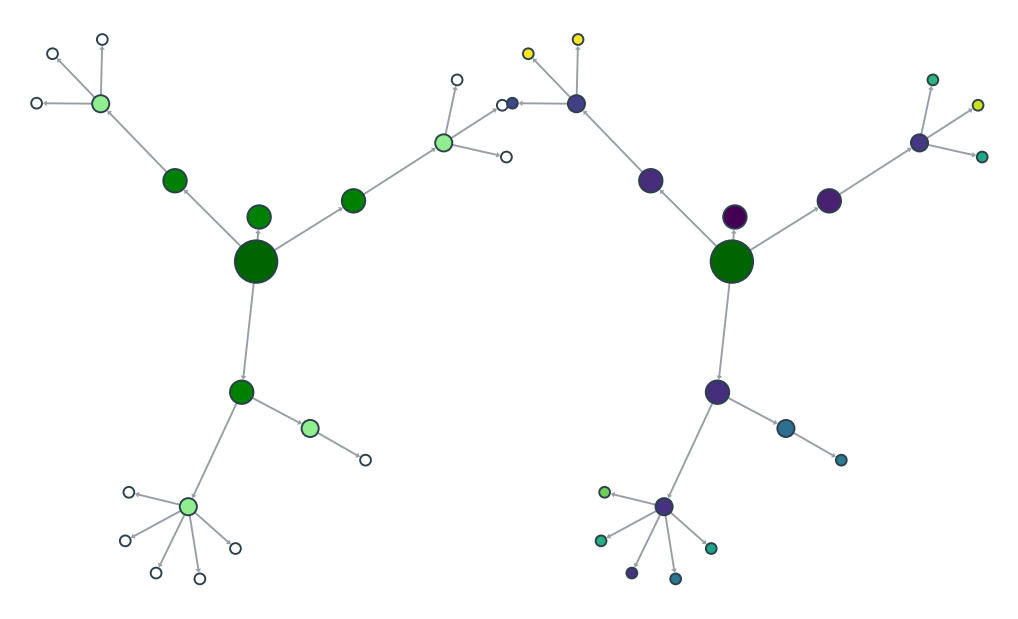

In [335]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 12))
Graph(nodes_n, 
      node_layout=pos, edge_layout='straight', 
      arrows=True, node_zorder=3, #edge_zorder=1,
      node_label_offset=0.02, 
      node_label_fontdict=dict(size=18, rotation=0, ha='center', clip_on=False), node_edge_width=0.2,
      node_size=node_size_n,  node_color=node_color_n, #edge_labels=edge_labels,
      edge_width=0.2, edge_label_fontdict=dict(size=10,),
      ax=ax1)
Graph(nodes_w, 
      node_layout=pos, edge_layout='straight', 
      arrows=True, node_zorder=3, #edge_zorder=1,
      node_label_offset=0.02, 
      node_label_fontdict=dict(size=18, rotation=0, ha='center', clip_on=False), node_edge_width=0.2,
      node_size=node_size_w,  node_color=node_color_w, #edge_labels=edge_labels,
      edge_width=0.2, edge_label_fontdict=dict(size=10,),
      ax=ax2)
plt.subplots_adjust(wspace=-0.1, hspace=0)
plt.show()
#plt.savefig('test.pdf', format='pdf', dpi=1200, bbox_inches='tight')

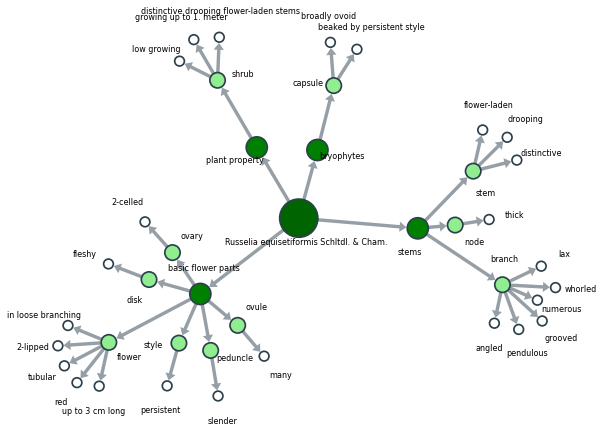

In [530]:
fig, ax = plt.subplots(figsize=(10, 10))
Graph(nodes_n, 
      node_layout=pos, edge_layout='straight', 
      arrows=True, node_zorder=3, #edge_zorder=1,
      node_label_offset=0.03, 
      node_labels=node_labels_n, 
      node_label_fontdict=dict(size=8, rotation=0, ha='center', clip_on=False), node_edge_width=0.2,
      node_size=node_size_n,  node_color=node_color_n, #edge_labels=edge_labels_n,
      edge_width=0.4, edge_label_fontdict=dict(size=4,),
      ax=ax)

#plt.savefig('kngraph_unweighted.pdf', format='pdf', dpi=1200, bbox_inches='tight')

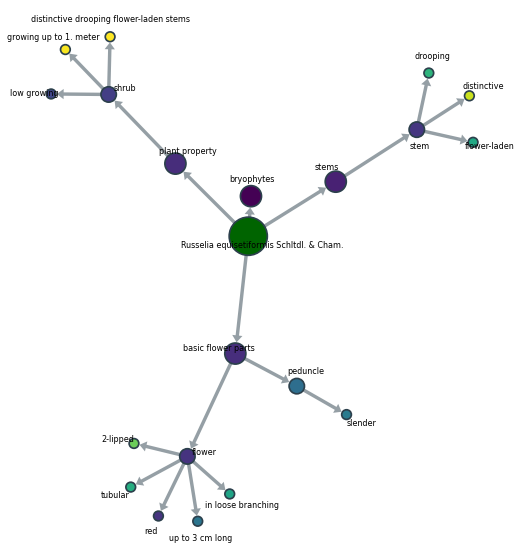

In [366]:
fig, ax = plt.subplots(figsize=(10, 10))
x = Graph(nodes_w, 
      node_layout=pos, edge_layout='straight', 
      arrows=True, node_zorder=3, #edge_zorder=1,
      node_label_offset=0.02, 
      node_labels=node_labels_w, 
      node_label_fontdict=dict(size=8, rotation=0, ha='center', clip_on=False), node_edge_width=0.2,
      node_size=node_size_w,  node_color=node_color_w, #edge_labels=edge_labels_n,
      edge_width=0.4, edge_label_fontdict=dict(size=7,),
      ax=ax)

#plt.savefig('kngraph_weighted.pdf', format='pdf', dpi=1200, bbox_inches='tight')

In [350]:
def possible_parts(species, data):
    return [obj for (_, (sub, rel, obj)) in data[species] if rel=='has main part']

In [351]:
parts = possible_parts(species, importance_dict)

In [654]:
parts[0]

'basic flower parts'

In [725]:
def create_weighted_graph(species, data, parts=False,
                          start=0, end=9999,
                          k=.08, scale=0.3, iterations=50, size=1.5,
                          log=True, seed=333):
    
    # Init variables
    baseparts, traits, source, relation, target, correct_parts = ([] for i in range(6))
    colors, node_size, node_color = ({} for i in range(3))
    low, high = (1, 0)
    cmap = matplotlib.cm.viridis
    
    # Drop useless parts
    if parts: 
        if type(parts) != list: parts = [parts]
        subparts = [obj for _, (sub, rel, obj) in data[species] if sub in parts]
        items = subparts + parts + ['species'] + [species]

    # Extract the data
    for color, (sub, rel, obj) in data[species][start:end]:
        if parts:
            if sub not in items:
                continue
            #else:
                #print((sub, rel, obj))
        if sub == 'species':
            sub = species
        source.append(sub), relation.append(rel), target.append(obj), 
        colors[obj] = color
        if rel == 'has main part':
            baseparts.append(obj)
        if rel == 'has part':
            traits.append(obj)
        # Set value range
        if low > color: low = color
        if high < color: high = color
    # Select color distribtution        
    if log: norm = mcolors.LogNorm(vmin=low, vmax=high)
    else: norm = mcolors.Normalize(vmin=low, vmax=high)        
    
    # Fit data into DF
    kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relation})
    # Extract the node names
    nodes = [(source, target) for source, target in zip(kg_df['source'].values, kg_df['target'].values)]
    # Init a graph
    G=nx.from_pandas_edgelist(kg_df, "source", "target", edge_attr=True, create_using=nx.Graph())
    # Extract the labels
    node_labels = {node : node for node in G}
    edge_labels = dict(zip(list(zip(kg_df.source, kg_df.target)), kg_df['edge'].tolist()))
    
    # Fil in the dict
    items += [item for (_, item) in nodes]
    for node in node_labels:
        if parts:
            if node not in items:
                continue
        if node == species:
            node_color[node] = 'darkgreen' 
            node_size[node] = 3.5/size
        else: 
            node_color[node] = cmap(norm(colors[node]))
            if node in baseparts: node_size[node] = 2/size
            elif node in traits: node_size[node] = 1.5/size
            else: node_size[node] = 1/size   
    
    # Determine position            
    pos = nx.spring_layout(G, k=k, iterations=iterations, seed=seed, scale=scale, center=(0,0), dim=2)
    
    return pos, nodes, node_size, node_color, node_labels, edge_labels

In [738]:
pos, nodes, node_size, node_color, node_labels, edge_labels = create_weighted_graph(species=species, 
                                                                               data=importance_dict, 
                                                                               end=999, log=True, parts=parts[2])

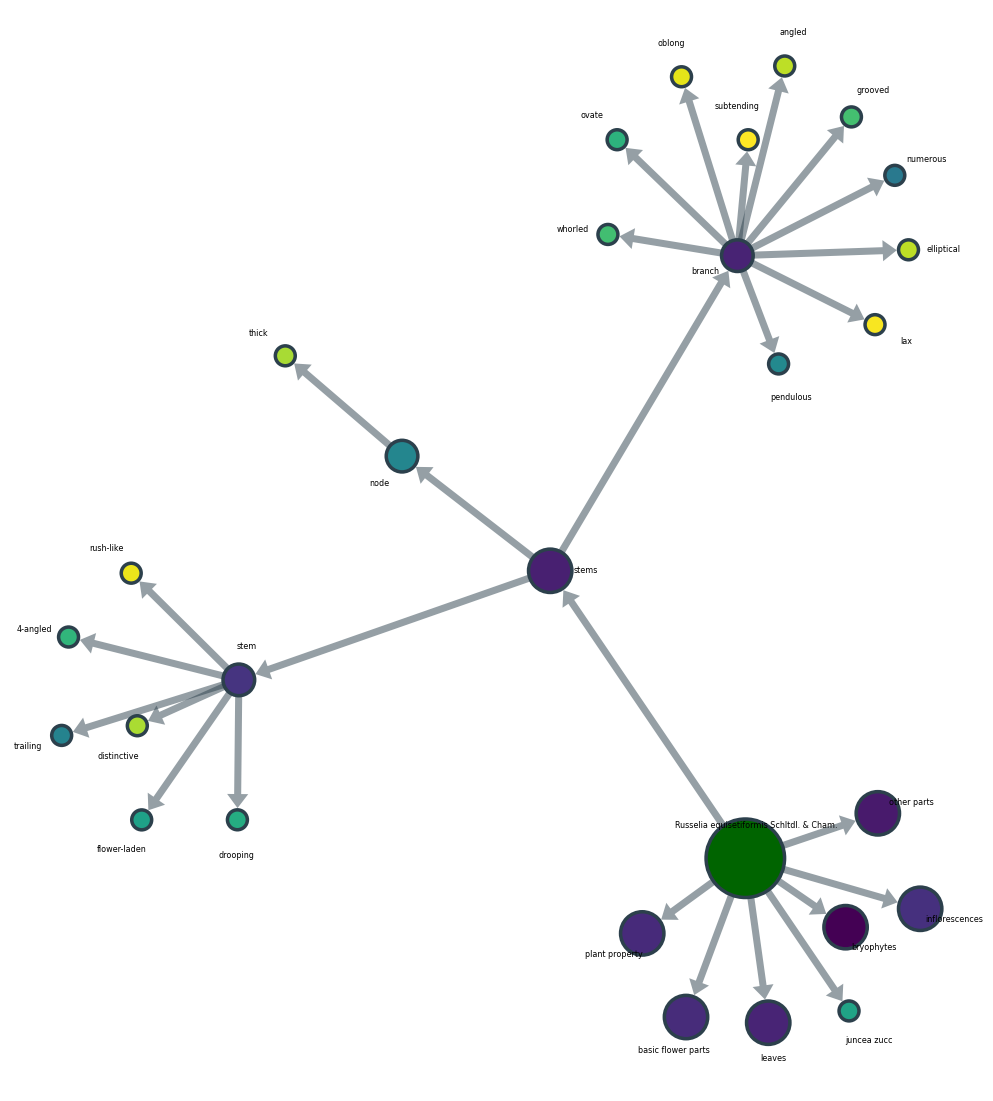

In [739]:
fig, ax = plt.subplots(figsize=(20, 20))
Graph(nodes, 
      node_layout=pos, edge_layout='straight', 
      arrows=True, node_zorder=3,
      node_label_offset=0.02, 
      node_labels=node_labels, node_color=node_color,
      node_label_fontdict=dict(size=8, rotation=0, ha='center', clip_on=False), node_edge_width=0.2,
      node_size=node_size,  
      edge_width=0.4,
      ax=ax)